In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nuance.utils import periodic_transit, tv_dv
import numpy as np
import tinygp
import jax
jax.config.update("jax_enable_x64", True)

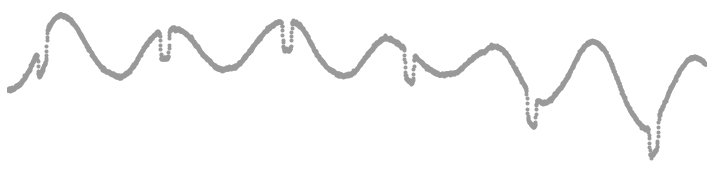

In [186]:
dt = 2/60/24
time = np.arange(0, 4, dt)
error = 0.0005
X = np.vander(time, N=4, increasing=True)
w = [1., 0.0005, -0.0002, -0.0005]
true_period = 0.7
duration, depth = 0.05, 0.02
t0 = 0.2
true_transit = periodic_transit(time, t0, duration, depth, P=true_period)
kernel = tinygp.kernels.quasisep.SHO(np.pi/(6*duration), 45., depth)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2)
vari = gp.sample(jax.random.PRNGKey(40))
diff_flux = true_transit + vari + X@w

plt.figure(None, (10, 2.5))
plt.plot(time, diff_flux, ".", c="0.6")
plt.xlabel("time (days)")
plt.ylabel("diff. flux")
plt.xlim(time.min(), time.max())
#plt.title("example dataset", loc="left")
plt.axis("off")
plt.tight_layout()

plt.savefig("../figures/principle_dataset.pdf")

In [187]:
from nuance import Nuance

In [188]:
nu = Nuance(time, diff_flux, error, kernel, X.T)

In [189]:
t0s = time.copy()
Ds = np.linspace(0.0001, 0.1, 30)
nu.linear_search(t0s, Ds)

  0%|          | 0/2880 [00:00<?, ?it/s]

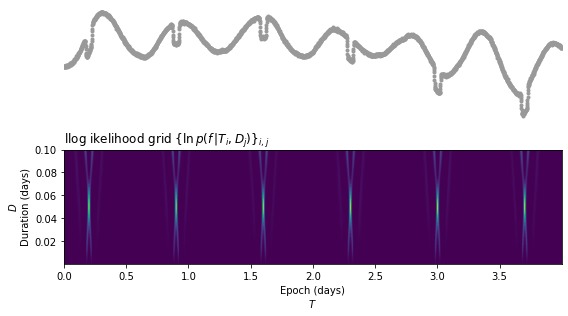

In [190]:
plt.figure(None, (8, 4.5))
plt.subplot(211)
plt.plot(time, diff_flux, ".", c="0.6")
plt.ylabel("diff. flux")
plt.xlim(time.min(), time.max())
plt.axis("off")

plt.subplot(212)
nu.search_data.show_ll()
plt.ylabel("$D$\nDuration (days)")
plt.xlabel("Epoch (days)\n$T$")
plt.title("llog ikelihood grid $\{\ln p(f\,| T_i,D_j)\}_{i,j}$", loc='left')
plt.tight_layout()

plt.savefig("../figures/principle_linear_search.pdf")

# Folds

In [191]:
periods = np.linspace(0.1, 3, 5000)
search = nu.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

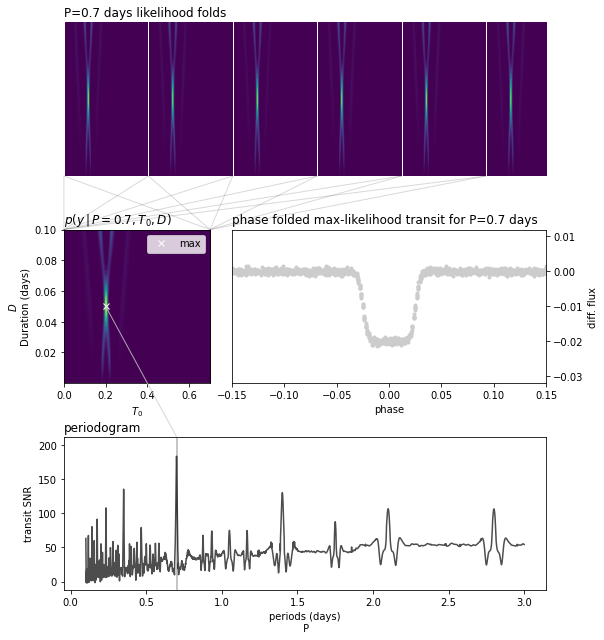

In [192]:
from nuance.utils import phase, binn
from matplotlib.patches import ConnectionPatch

plt.figure(None, (8.5, 9))

P = true_period
folds = nu.search_data.folds
pt0s, (fll, _, _) = folds(P)#true_period)
extent = 0, 1*true_period, nu.search_data.Ds.min(), nu.search_data.Ds.max()

ax0=plt.subplot(3, 3, (1, 3))
nu.search_data.show_ll()
plt.xlim(nu.time.min(), nu.time.max())
plt.axis("off")

ax2 = plt.subplot(3, 3, 4)
plt.imshow(fll.sum(0).T, aspect='auto', extent=extent, origin="lower")
plt.xlabel("$T_0$")
plt.ylabel("$D$\nDuration (days)")
plt.plot(t0, duration, "x", c="w", label="max")
plt.title(f"$p(y \,|\,P={P},T_0,D)$", loc="left")
plt.legend()

ax = plt.subplot(3, 3, (5, 6))
mean, astro, noise = nu.models(t0, duration, P)
phi = phase(nu.time, t0, true_period)
detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
#plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*3*duration))
_depth = float(np.abs(astro.min()))
plt.ylim(*(np.array([-1, 1])*_depth*1.1 - _depth/2))
plt.xlabel("phase")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_title(f"phase folded max-likelihood transit for P={P} days", loc="left")
plt.ylabel("diff. flux")

c="k"
alpha = .15
for i in range(int(np.ceil((nu.time.max() -  nu.time.min())/P))):
    ax0.axvline(i*P, c="w", lw=1)
    con = ConnectionPatch(xyA=(1., 1.), xyB=(i*P, 0.), coordsA="axes fraction", coordsB="data", axesA=ax2, axesB=ax0, color=c, zorder=-1, alpha=alpha)
    ax.add_artist(con)
    con = ConnectionPatch(xyA=(0., 1.), xyB=(i*P, 0.), coordsA="axes fraction", coordsB="data", axesA=ax2, axesB=ax0, color=c, zorder=-1, alpha=alpha)
    ax.add_artist(con)

ax0.set_title(f"P={P} days likelihood folds", loc="left", zorder=10)
ax.set_zorder(2)
ax0.set_zorder(1)

ax_per = plt.subplot(3, 3, (7, 9))
ax_per.plot(*search.periodogram(), c="0.3")
ax_per.set_title("periodogram", loc="left")
ax_per.set_xlabel("periods (days)\n P")
ax_per.set_ylabel("transit SNR")
ax_per.axvline(true_period, c="k", alpha=0.3)
ylim = np.array(ax_per.get_ylim())
ax_per.set_ylim(*(ylim*1.1))
con = ConnectionPatch(xyA=(t0, duration), xyB=(true_period, ax_per.get_ylim()[1]), coordsA="data", coordsB="data", axesA=ax2, axesB=ax_per, color="0.8", alpha=0.8)
ax.add_artist(con)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.35)
plt.savefig("../figures/principle_tiles_combined.pdf")